### Dependências

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np 
from pandas import read_excel
from scipy.optimize import curve_fit
import math
from statistics import mean
import copy as copy

### Importação de dados

In [ ]:
df = pd.read_excel('Planilha do raio-x.xlsx', sheet_name='Dados', header=None, names=['A', 'B', 'C', 'D','E', 'F'])
df = df.replace({',': '.'}, regex=True)
hs = pd.read_excel('Planilha do raio-x.xlsx', sheet_name='Hist', header=None, names=['A', 'B'])
tm = pd.read_excel('Planilha do raio-x.xlsx', sheet_name='TMorto', header=None, names=['A', 'B'])
tm = tm.replace({',':'.'}, regex=True)
abs = pd.read_excel('Planilha do raio-x.xlsx', sheet_name='Absortancia', header=None, names=['A', 'B', 'C', 'D'])
abs = abs.replace({',': '.'}, regex=True)

### Histograma

In [ ]:
def gaussB(x, a, b, N):
    return N*(1/(a*(2*math.pi)**(1/2)))*np.exp((-(x-b)**2/(2*a**2)))

Nbins = int(math.sqrt(mean(hs['B']))/3)



ListaOrdHist = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
LarguraBarra = (max(hs['B']) - min(hs['B']))/10
ListaAbsHist = []

for i in range(10):
    for j in range(len(hs['B'])):
        if min(hs['B']) + i*LarguraBarra  <= hs['B'][j] <= min(hs['B']) + (i+1)*LarguraBarra:
            ListaOrdHist[i] = ListaOrdHist[i] + 1
    ListaAbsHist = ListaAbsHist + [min(hs['B']) + LarguraBarra*i + LarguraBarra/2]


poptHist, pcovHist = curve_fit(gaussB, ListaAbsHist, ListaOrdHist, bounds=([10, 930, 0], [60, 1000, 5000]), absolute_sigma=True) #a, b, N

rgBL2 = np.linspace(850, 1100, 100)


plt.hist(hs['B'], bins=Nbins, color='c')
plt.plot(rgBL2, gaussB(rgBL2, *poptHist), marker = '.', color = 'Gray', label='Ajuste Gaussiano')
plt.legend()
plt.xlabel('Número de Fótons')
plt.ylabel('Frequência')
plt.grid()
plt.show()

print(poptHist,'\n', pcovHist)

SigmaHist = poptHist[0]
print(SigmaHist)
print(mean(hs['B'])**(1/2))


### Caracterização do tempo morto 

In [ ]:
tm['C'] = np.sqrt(tm['B'])
tm['D'] = 0.005

def ajusteTempoMorto(x,a,b):
    return a*x + b

def ajusteTempoMorto2(R,t):
    return(R/(R*t+1))


tmAjuste1 = tm.query('0 <= A <= 0.4')


poptTM, pcovTM = curve_fit(ajusteTempoMorto, tmAjuste1['A'], tmAjuste1['B'], sigma=tmAjuste1['C'], absolute_sigma=True)

print('Parâmetro a:', poptTM[0], '\nIncerteza Parâmetro a:', np.sqrt(pcovTM[0][0]) ,'\nParâmetro b:', poptTM[1], '\nIncerteza Parâmetro b:', np.sqrt(pcovTM[1][1]))

x1 = np.linspace(0,1,200)

plt.errorbar(tm['A'], tm['B'], tm['C'], tm['D'], '.k')
plt.plot(x1,ajusteTempoMorto(x1,poptTM[0],poptTM[1]), 'k')
plt.xlabel('Intensidade de corrente (mA)')
plt.ylabel('Contagem máxima de fótons')
plt.grid()
plt.show()

tm['E'] = 1/tm['A']
tm['F'] = 1/ajusteTempoMorto(tm['A'],poptTM[0],poptTM[1])
tm['G'] = tm['F']**2 * np.sqrt((tm['A'])**2 * pcovTM[0][0] + pcovTM[1][1])
tm['H'] = tm['E']**2 * tm['D']

poptTM2, pcovTM2 = curve_fit(ajusteTempoMorto, tm['E'], tm['F'], sigma=tm['G'], absolute_sigma = True)
print('Parâmetro a:', poptTM2[0], '\nIncerteza Parâmetro a:', np.sqrt(pcovTM2[0][0]) ,'\nParâmetro b (TEMPO MORTO):', poptTM2[1], '\nIncerteza Parâmetro b (TEMPO MORTO):', np.sqrt(pcovTM2[1][1]))

x2 = np.linspace(0,20,200)

plt.errorbar(tm['E'], tm['F'], tm['G'], tm['H'], '.k')
plt.plot(x2,ajusteTempoMorto(x2,poptTM2[0],poptTM2[1]), 'k')
plt.xlabel("Inverso da Corrente (1/mA)")
plt.ylabel("Inverso da Contagem máxima de fótons")
plt.grid()
plt.show()

df['B'] = df['B']/(1-(pcovTM2[1][1]*df['B']))
df['C'] = df['C']/(1-(pcovTM2[1][1]*df['C']))
df['D'] = df['D']/(1-(pcovTM2[1][1]*df['D']))
df['E'] = df['E']/(1-(pcovTM2[1][1]*df['E']))
df['F'] = df['F']/(1-(pcovTM2[1][1]*df['F']))

TempoMorto = poptTM2[1]
SigmaTMorto = np.sqrt(pcovTM2[1][1])


'''
# R = a*x + b, sendo que a e b são os parametros ajustados pela função ajusteTempoMorto(x,a,b)

def ajusteTempoMorto2(x,t):
    return((poptTM[0]*x+poptTM[1])/((poptTM[0]*x+poptTM[1])*t+1))

poptTM3, pcovTM3 = curve_fit(ajusteTempoMorto2, tmAjuste1['A'], tmAjuste1['B'], bounds=([0.00001], [0.001]))

plt.errorbar(tm['A'], tm['B'], tm['C'], tm['D'], '.k')
plt.plot(x1,ajusteTempoMorto2(x1,*poptTM3), 'k')
plt.xlabel('Intensidade de corrente (mA)')
plt.ylabel('Contagem máxima de fótons')
plt.grid()
plt.show()

print('Parâmetro t:', poptTM3[0])'''




### Plot 35KV, 30KV, 28KV, 25KV, 18KV

In [ ]:
plt.figure(figsize=(10.5, 9))

plt.plot(df['A'], df['B'], label='35KV', marker='.', color='Blue')
plt.plot(df['A'], df['C'], label='30KV', marker='.', color='Red')
plt.plot(df['A'], df['D'], label='28KV', marker='.', color='Yellow')
plt.plot(df['A'], df['E'], label='25KV', marker='.', color='Green')
plt.plot(df['A'], df['F'], label='18KV', marker='.', color='Orange')
plt.xlabel('Angulo(*)')
plt.ylabel('Número de fótons por segundo')
plt.grid()
plt.legend()
plt.show()

### Calculo de I_a / I_b == n_a / n_b pela hipótese de planck, e posterior análise de picos

In [ ]:
cores = ['Blue', 'Red', 'Yellow', 'Green', 'Orange']
voltagens =['35KV', '30KV', '28KV', '25KV', '18KV']
grafs = ['B', 'C', 'D', 'E', 'F']
def AnalisePicos(cor, voltagem, graf):
    
    def gauss(x, a, b, N, c):
        return c + N*np.exp((-(x-b)**2/(2*a)))


    for w in range(3):
        selecANG =[]
        selecTaxaMedidaNF = []
        for i in range(0, 275):
            if df['A'][i] >= 5.01 + 6.5*w  and df['A'][i] <= 9 + 7*w :
                selecANG.append(df['A'][i])
                selecTaxaMedidaNF.append(df[graf][i])
        
        selecNF = []
        for i in range(len(selecTaxaMedidaNF)):
            selecNF = selecNF + [selecTaxaMedidaNF[i]/(1-TempoMorto*selecTaxaMedidaNF[i])]

        plt.figure    (figsize=(10.5, 9))
        plt.plot(selecANG, selecNF, label=voltagem, marker='.', color=cor )
        plt.xlabel('Angulo(*)')
        plt.ylabel('Número de fótons por segundo')
        plt.grid()
        plt.legend()
        plt.show()
        
        
        if cor != 'Orange':
            
            #calculo dos I_alfa e I_beta
            ListaOrdenadasPico1 = [] #lista das ordenadas dos pontos proximos ao pico 1
            ListaAbsPico1 = [] #lista das abissiças dos pontos proximos ao pico 1
            Npico1 = 0 #Posição (ou indice) das coordenadas do pico 1 nas lista selecANG e selecNF
            
            ListaOrdenadasPico2 = [] #lista das ordenadas dos pontos proximos ao pico 2
            ListaAbsPico2 = [] #lista das abissiças dos pontos proximos ao pico 2
            
            selecNFtiraPico1 = copy.deepcopy(selecNF)
            selecANGtiraPico1 = copy.deepcopy(selecANG)
            
            
            "Dangulo = 0.005"
            
            for i in range(len(selecNF)):
                if selecNF[i]==max(selecNF):
                    Npico1 = i
            for i in range(7):
                ListaOrdenadasPico1 = ListaOrdenadasPico1 + [selecNF[Npico1-3+i]]
                ListaAbsPico1 = ListaAbsPico1 + [selecANG[Npico1-3+i]]
                del selecNFtiraPico1[Npico1-3]
                del selecANGtiraPico1[Npico1-3]


            for i in range(len(selecNFtiraPico1)):
                if selecNFtiraPico1[i]==max(selecNFtiraPico1):
                    Npico2 = i
            for i in range(7):
                ListaOrdenadasPico2 = ListaOrdenadasPico2 + [selecNFtiraPico1[Npico2-3+i]]
                ListaAbsPico2 = ListaAbsPico2 + [selecANGtiraPico1[Npico2-3+i]]

            #def LigaGrafico(x, x1, y1, x2, y2):
                #return(x*(y1-y2)/(x1-x2) + (x1*y2-x2*y1)/(x1-x2))



            #Calculo das incertezas:
            ListaSigmaOrdPico1 = []
            ListaSigmaOrdPico2 = []
            
            for i in range(len(ListaOrdenadasPico1)):
                TaxaMedidaPico1 = ListaOrdenadasPico1[i]/(ListaOrdenadasPico1[i]*TempoMorto + 1)
                if len(ListaOrdenadasPico2)-1 > i > 0:
                    dF1dx = (ListaOrdenadasPico1[i+1] - ListaOrdenadasPico1[i-1])/0.2
                elif i == 0:
                    dF1dx = (ListaOrdenadasPico1[1] - selecNF[Npico1-4])/0.2
                else:
                    dF2dx = (selecNF[Npico1+4] - ListaOrdenadasPico1[i-1])/0.2
                ListaSigmaOrdPico1 = ListaSigmaOrdPico1 + [((TaxaMedidaPico1**(1/2)/(TaxaMedidaPico1*TempoMorto-1)**2)**2 + (SigmaTMorto*TaxaMedidaPico1**2/(TempoMorto*TaxaMedidaPico1-1)**2)**2 + (dF1dx*0.005)**2)**(1/2)]
            
            for i in range(len(ListaOrdenadasPico2)):
                TaxaMedidaPico2 = ListaOrdenadasPico2[i]/(ListaOrdenadasPico2[i]*TempoMorto + 1)
                if len(ListaOrdenadasPico2)-1 > i > 0:
                    dF2dx = (ListaOrdenadasPico2[i+1] - ListaOrdenadasPico2[i-1])/0.2
                elif i == 0:
                    dF2dx = (ListaOrdenadasPico2[1] - selecNF[Npico2-4])/0.2
                else:
                    dF2dx = (selecNF[Npico2+4] - ListaOrdenadasPico2[i-1])/0.2
                ListaSigmaOrdPico2 = ListaSigmaOrdPico2 + [((TaxaMedidaPico2**(1/2)/(TaxaMedidaPico2*TempoMorto-1)**2)**2 + (SigmaTMorto*TaxaMedidaPico2**2/(TempoMorto*TaxaMedidaPico2-1)**2)**2 + (dF2dx*0.005)**2)**(1/2)]
                

            poptP1, pcovP1 = curve_fit(gauss, ListaAbsPico1, ListaOrdenadasPico1, bounds=([0, ListaAbsPico1[1], 0, 0], [10, ListaAbsPico1[5], 3000, 300]), sigma=ListaSigmaOrdPico1, absolute_sigma=True) #a, b, N, c
            poptP2, pcovP2 = curve_fit(gauss, ListaAbsPico2, ListaOrdenadasPico2, bounds=([0, ListaAbsPico2[1], 0, 0], [10, ListaAbsPico2[5], 1500, 300]), sigma=ListaSigmaOrdPico2, absolute_sigma=True) #a, b, N, c
            
            print('Para o pico alfa : \n','a = ', poptP1[0], '\n','b = ', poptP1[1], '\n', 'N = ', poptP1[2], '\n', 'c = ', poptP1[3], '\n', 'Matriz de covariancia : \n', pcovP1, '\n', 'Ajuste do pico alfa já considerando incertezas :' )#a, b, N, c
            
            #poptP1 é a lista dos valores dos parametros ajustados do pico 1
            #pcovP1 é a matriz de covariancia. As incertezas são as raizesdos elementos da diagonal principal
            
            rgBL = np.linspace(ListaAbsPico1[0], ListaAbsPico1[6], num = 100) #rgBL é um range continuo (100 pontos) entre 6.9 e 7.5

            plt.figure(figsize=(10.5, 9))
            plt.plot(ListaAbsPico1, ListaOrdenadasPico1, label=voltagem, marker='.', color=cor )
            plt.plot(rgBL, gauss(rgBL, *poptP1), label=voltagem, marker='.', color='gray' )
            plt.xlabel('Angulo(*)')
            plt.ylabel('Número de fótons por segundo')
            plt.grid()
            plt.legend()
            plt.show()
            
            
            
            print('Para o pico Beta : \n','a = ', poptP2[0], '\n','b = ', poptP2[1], '\n', 'N = ', poptP2[2], '\n', 'c = ', poptP2[3], '\n', 'Matriz de covariancia : \n', pcovP2, '\n', 'Ajuste do pico beta já considerando incertezas :' )
            
            #poptP1 é a lista dos valores dos parametros ajustados do pico 1
            #pcovP1 é a matriz de covariancia. As incertezas são as raizesdos elementos da diagonal principal
            
            rgBL = np.linspace(ListaAbsPico2[0], ListaAbsPico2[6], num = 100) #rgBL é um range continuo (100 pontos) entre 6.9 e 7.5

            plt.figure(figsize=(10.5, 9))
            plt.plot(ListaAbsPico2, ListaOrdenadasPico2, label=voltagem, marker='.', color=cor )
            plt.plot(rgBL, gauss(rgBL, *poptP2), label=voltagem, marker='.', color='gray' )
            plt.xlabel('Angulo(*)')
            plt.ylabel('Número de fótons por segundo')
            plt.grid()
            plt.legend()
            plt.show()

            
            RazãoIKaIKb = [(poptP1[2]+poptP1[3])/(poptP2[2]+poptP2[3]), ((1/(poptP2[2]+poptP2[3]) * pcovP1[2][2]**(1/2))**2 + (1/(poptP2[2]+poptP2[3]) * pcovP1[3][3]**(1/2))**2 + ((poptP1[2]+poptP1[3])/(poptP2[2]+poptP2[3])**2 * pcovP2[2][2]**(1/2))**2 + ((poptP1[2]+poptP1[3])/(poptP2[2]+poptP2[3])**2 * pcovP2[3][3]**(1/2))**2)**(1/2)]
            print('Razão', RazãoIKaIKb)
            # Ajuste primitivo
    




for j in range(0, 5):
    AnalisePicos(cor=cores[j], voltagem=voltagens[j], graf=grafs[j])
    



## Cálculo da <font color='#7ac77a'>constante de Planck</font> 
--------------------------------------------
Para isso vamos fazer o seguinte procedimento: 
- 1) vamos pegar os primeiros valores do gráfico de angulos
- 2) passar os dádos para comprimento de onda
- 3) ajusta-los com a função do Breinstrung que vamos obter do multiplot 
- 4) usar essa relação para achar h
----------------------

In [ ]:
def Linear(x, a, b):
    return(a*x+b)

AngsMin = []
SigmaAngsMin = []

Angulos = []
Contagens = []



for i in range(4):
    for j in range(275):
        Angulos = Angulos + [df['A'][j]]
        Contagens = Contagens + [df[grafs[i]][j]]
    
    Contagens = df[grafs[i]]
    for j in range(50):
        if Contagens[j] >= 30:
            InicioDoAjuste = j
            break
    SelecAngLinear = []
    SelecNFLinear = []
    SigmaSelecAngLinear = []
    SigmaSelecNFLinear = []
    
    for k in range(5):
        
        SelecAngLinear.append(Angulos[InicioDoAjuste + k])
        #SelecAngLinear = SelecAngLinear + [Angulos[InicioDoAjuste + k]]
        SelecNFLinear = SelecNFLinear + [Contagens[InicioDoAjuste + k]]
        SigmaSelecNFLinear = SigmaSelecNFLinear + [((Contagens[InicioDoAjuste + k]) + (((Contagens[InicioDoAjuste + 1] - Contagens[InicioDoAjuste])/0.1)*0.005)**2)**(1/2)]
    poptLb, pcovLb = curve_fit(Linear, SelecAngLinear, SelecNFLinear, sigma=SigmaSelecNFLinear, absolute_sigma=True)
    
    AngsMin = AngsMin + [-poptLb[1]/poptLb[0]]
    SigmaAngsMin = SigmaAngsMin + [((pcovLb[0][0]**(1/2)*poptLb[1]/poptLb[0]**2)**2 + (pcovLb[1][1]**(1/2)/poptLb[0]))**(1/2)]
    
        
print(AngsMin, SigmaAngsMin)

# Zoom no inicio do multiplot 
def zoom(xlmin, xlmax, ylmin, ylmax):
    plt.figure(figsize=(10.5, 9))
    plt.plot(df['A'], df['B'], label='35KV', marker='.', color='Blue')
    plt.plot(df['A'], df['C'], label='30KV', marker='.', color='Red')
    plt.plot(df['A'], df['D'], label='28KV', marker='.', color='Yellow')
    plt.plot(df['A'], df['E'], label='25KV', marker='.', color='Green')
    plt.plot(df['A'], df['F'], label='18KV', marker='.', color='Orange')
    plt.xlabel('Angulo(*)')
    plt.ylabel('Número de fótons por segundo')
    plt.xlim(xlmin, xlmax)
    plt.ylim(ylmin, ylmax)
    plt.grid()
    plt.legend()
    plt.show()
    
def Tensão(x, a):
    return  a/x

# Achar o Lambda mínimo 
def Bragg(AngMin):
    d = 0.282e-9
    #n = 1 
    # Retorna o lambda mínimo
    return 2*d*math.sin(AngMin)

def hgenerator2():
    e = -1.602176634e-19 # C
    # a = hc/e
    c = 299792458 # m/s
    h = -poptfin[0]*e/c
    sigma_h = -sig_a*e/c
    return h, sigma_h

def sigma_ldmin(theta, delta_theta):
    # Convertendo ângulos para radianos
    theta_rad = np.radians(theta)
    delta_theta_rad = np.radians(delta_theta)
    
    # Calculando a incerteza em lambda_min
    delta_lambda = np.sqrt((2 * 0.282e-9 * np.cos(theta_rad) * delta_theta_rad)**2 + 
                           ((2 * 0.282e-9) * np.cos(theta_rad) * delta_theta_rad)**2)
    
    return delta_lambda    

SigmaLambdasMin = [] 
for i in range(4):
    SigmaLambdasMin = SigmaLambdasMin + [sigma_ldmin(AngsMin[i], SigmaAngsMin[i])]

voltagens = [35000, 30000, 28000, 25000] # V
sigmaV = [350, 300, 280, 250] # Sigma voltz em V
#AngsMin =[3.75, 4.5, 5.25, 5.75]  Teta mínimo da Ivy
lambdas = []

SigmaFin =[]

for i in range(0, len(AngsMin)):
    lamb = Bragg(math.radians(AngsMin[i]))
    lambdas.append(lamb)
    print('Comprimento de onda para', str(voltagens[i]), 'É igual a : ', lamb)
    SigmaFin = SigmaFin + [((sigmaV[i])**2 + (SigmaLambdasMin[i]*voltagens[i]/lambdas[i])**2)**(1/2)]

poptfin, pcovfin = curve_fit(Tensão, lambdas, voltagens, sigma=SigmaFin, absolute_sigma=True)

sig_a = math.sqrt(pcovfin[0][0])

zoom(2.3, 9, 0, 200)
print('a =', poptfin[0], ' \n Incerteza do parâmetro a : \n', sig_a )
h, sigma_h = hgenerator2()
print('h =', h, ' \n Incerteza de h : \n', sigma_h )


dataPlotx = np.linspace(2.5*10**(-11), 4.5*10**(-11), 80)
plt.figure(figsize=(10.5, 9)) # Inputs lambdas, output tensões. Ajuste V = a/lambda
plt.errorbar(lambdas, voltagens, yerr=SigmaFin, fmt = 'o', markerfacecolor = 'gray', markeredgecolor = 'black', ecolor='gray', capsize= 5, label = 'Pontos Medidos')
plt.plot(dataPlotx, Tensão(dataPlotx, *poptfin), marker ='.', label = 'Ajuste', color = 'black', markersize = '4' )
plt.title('Dados de V0 e frequência ajustados segundo o modelo de V = a/lambda')
plt.xlabel('Lambda Mínimo')
plt.ylabel('Voltagem')
plt.legend()
plt.grid()
plt.show()

print(lambdas)
print(voltagens)
print(sigmaV)
print(SigmaFin)
print(poptfin[0])
print((pcovfin[0]))

Análise das Energias de cada pico removendo a energia de fundo de Bremsstrahlung

In [ ]:
cores = ['Blue', 'Red', 'Yellow', 'Green', 'Orange']
voltagens =['35KV', '30KV', '28KV', '25KV', '18KV']
grafs = ['B', 'C', 'D', 'E', 'F']

def AnaliseEnergias(cor, voltagem, graf):

    def gauss(x, a, b, N, c):
            return c + N*np.exp((-(x-b)**2/(2*a)))


    selecANG =[]
    selecTaxaMedidaNF = []
    for i in range(0, 275):
        if df['A'][i] >= 5.01  and df['A'][i] <= 9:
            selecANG.append(df['A'][i])
            selecTaxaMedidaNF.append(df[graf][i])

    selecNF = []
    for i in range(len(selecTaxaMedidaNF)):
        selecNF = selecNF + [selecTaxaMedidaNF[i]/(1-TempoMorto*selecTaxaMedidaNF[i])]


    ListaOrdenadasPico1 = [] #lista das ordenadas dos pontos proximos ao pico 1
    ListaAbsPico1 = [] #lista das abissiças dos pontos proximos ao pico 1
    Npico1 = 0 #Posição (ou indice) das coordenadas do pico 1 nas lista selecANG e selecNF

    ListaOrdenadasPico2 = [] #lista das ordenadas dos pontos proximos ao pico 2
    ListaAbsPico2 = [] #lista das abissiças dos pontos proximos ao pico 2


    selecANGtiraPico1 = copy.deepcopy(selecANG)
    selecNFtiraPico1 = copy.deepcopy(selecNF)


    "Dangulo = 0.005"

    for i in range(len(selecNF)):
        if selecNF[i]==max(selecNF):
            Npico1 = i



    for i in range(7):
        del selecNFtiraPico1[Npico1-3]
        del selecANGtiraPico1[Npico1-3]






    for i in range(len(selecNFtiraPico1)):
        if selecNFtiraPico1[i]==max(selecNFtiraPico1):
            Npico2 = i



    def LigaGrafico(x, x1, y1, x2, y2):
        return(x*(y1-y2)/(x1-x2) + (x1*y2-x2*y1)/(x1-x2))

    PontosLigaGrafico = [Npico2 - 3, Npico1 + 5]

    selecNFTiraB = []
    for i in range(len(selecNF)):
        selecNFTiraB = selecNFTiraB + [selecNF[i]-LigaGrafico(selecANG[i], selecANG[PontosLigaGrafico[0]], selecNF[PontosLigaGrafico[0]], selecANG[PontosLigaGrafico[1]], selecNF[PontosLigaGrafico[1]])]

    selecNFtiraBtiraPico1 = copy.deepcopy(selecNFTiraB)


    for i in range(7):
        ListaOrdenadasPico1 = ListaOrdenadasPico1 + [selecNFTiraB[Npico1-3+i]]
        ListaAbsPico1 = ListaAbsPico1 + [selecANG[Npico1-3+i]]
        del selecNFtiraBtiraPico1[Npico1-3]


    for i in range(7):
        ListaOrdenadasPico2 = ListaOrdenadasPico2 + [selecNFtiraBtiraPico1[Npico2-3+i]]
        ListaAbsPico2 = ListaAbsPico2 + [selecANGtiraPico1[Npico2-3+i]]


    ListaSigmaOrdPico1 = []
    ListaSigmaOrdPico2 = []

    for i in range(len(ListaOrdenadasPico1)):
        TaxaMedidaPico1 = ListaOrdenadasPico1[i]/(ListaOrdenadasPico1[i]*TempoMorto + 1)
        if len(ListaOrdenadasPico2)-1 > i > 0:
            dF1dx = (ListaOrdenadasPico1[i+1] - ListaOrdenadasPico1[i-1])/0.2
        elif i == 0:
            dF1dx = (ListaOrdenadasPico1[1] - selecNFTiraB[Npico1-4])/0.2
        else:
            dF2dx = (selecNFTiraB[Npico1+4] - ListaOrdenadasPico1[i-1])/0.2
        ListaSigmaOrdPico1 = ListaSigmaOrdPico1 + [((TaxaMedidaPico1**(1/2)/(TaxaMedidaPico1*TempoMorto-1)**2)**2 + (SigmaTMorto*TaxaMedidaPico1**2/(TempoMorto*TaxaMedidaPico1-1)**2)**2 + (dF1dx*0.005)**2)**(1/2)]

    for i in range(len(ListaOrdenadasPico2)):
        TaxaMedidaPico2 = ListaOrdenadasPico2[i]/(ListaOrdenadasPico2[i]*TempoMorto + 1)
        if len(ListaOrdenadasPico2)-1 > i > 0:
            dF2dx = (ListaOrdenadasPico2[i+1] - ListaOrdenadasPico2[i-1])/0.2
        elif i == 0:
            dF2dx = (ListaOrdenadasPico2[1] - selecNFTiraB[Npico2-4])/0.2
        else:
            dF2dx = (selecNFTiraB[Npico2+4] - ListaOrdenadasPico2[i-1])/0.2
        ListaSigmaOrdPico2 = ListaSigmaOrdPico2 + [((TaxaMedidaPico2**(1/2)/(TaxaMedidaPico2*TempoMorto-1)**2)**2 + (SigmaTMorto*TaxaMedidaPico2**2/(TempoMorto*TaxaMedidaPico2-1)**2)**2 + (dF2dx*0.005)**2)**(1/2)]


    poptKa, pcovKa = curve_fit(gauss, ListaAbsPico1, ListaOrdenadasPico1, bounds=([0, ListaAbsPico1[1], 0, 0], [10, ListaAbsPico1[5], 3000, 300]), sigma=ListaSigmaOrdPico1, absolute_sigma=True) #a, b, N, c
    poptKb, pcovKb = curve_fit(gauss, ListaAbsPico2, ListaOrdenadasPico2, bounds=([0, ListaAbsPico2[1], 0, 0], [10, ListaAbsPico2[5], 3000, 300]), sigma=ListaSigmaOrdPico2, absolute_sigma=True)
    rgBL = np.linspace(ListaAbsPico1[0], ListaAbsPico1[6], num = 100)
    rgBL2 = np.linspace(ListaAbsPico2[0], ListaAbsPico2[6], num = 100)

    plt.figure(figsize=(10.5, 9))
    plt.plot(selecANG, selecNFTiraB, marker='.', color=cor)
    plt.plot(rgBL, gauss(rgBL, *poptKa), marker = '.', color='black')
    plt.plot(rgBL2, gauss(rgBL2, *poptKb), marker = '.', color='black')
    plt.xlabel('Angulo(*)')
    plt.ylabel('Número de fótons por segundo')
    plt.grid()
    plt.legend()
    plt.show()




    c = 299792458
    d = 0.282e-9

    EnergiaKa = h*c/(2*d*math.sin(poptKa[1]))
    EnergiaKb = h*c/(2*d*math.sin(poptKb[1]))
    SigmaEnergiaKa = ((sigma_h*c/(2*d*math.sin(poptKa[1])))**2 + (pcovKa[1][1]**(1/2)*h*c/(2*d)*math.cos(poptKa[2])/(math.sin(poptKa[2]))**2)**2)**(1/2)
    SigmaEnergiaKb = ((sigma_h*c/(2*d*math.sin(poptKb[1])))**2 + (pcovKb[1][1]**(1/2)*h*c/(2*d)*math.cos(poptKb[2])/(math.sin(poptKb[2]))**2)**2)**(1/2)
    print('Energia Ka:', EnergiaKa,'\nIncerteza Energia Ka:',SigmaEnergiaKa,'\nEnergia Kb:',EnergiaKb,'\nIncerteza Energia Kb:',SigmaEnergiaKb)


for j in range(0, 3):
    AnaliseEnergias(cor=cores[j], voltagem=voltagens[j], graf=grafs[j])

### Análise da Absortância dos Materiais

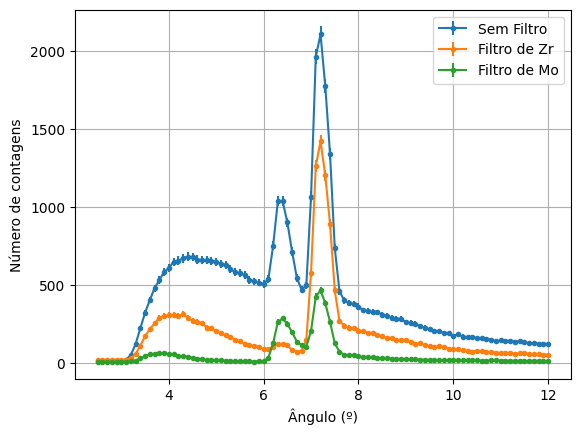

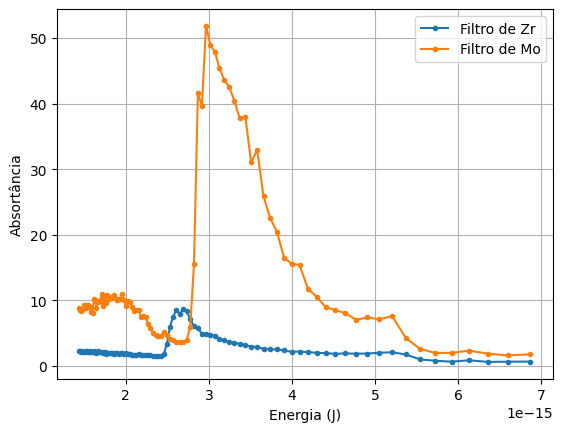

Espessura do Molibdênio: 0.0005195655796134775
Incerteza Espessura do Molibdênio: 15.78337874760581
Espessura do Zircônio: 0.00020750483100572223
Incerteza Espessura do Zircônio: 12.466608950776727


In [234]:
# Criando novas colunas com as incertezas dos valores, incluindo a correção do tempo morto.
abs['E'] = 0.005
abs['F'] = np.sqrt((np.sqrt(abs['B'])/(1-abs['B']*poptTM2[1])**2)**2 + (((abs['B']*poptTM2[1])/(1-abs['B']*poptTM2[1])**2)*np.sqrt(pcovTM2[1][1]))**2)
abs['G'] = np.sqrt((np.sqrt(abs['C'])/(1-abs['C']*poptTM2[1])**2)**2 + (((abs['C']*poptTM2[1])/(1-abs['C']*poptTM2[1])**2)*np.sqrt(pcovTM2[1][1]))**2)
abs['H'] = np.sqrt((np.sqrt(abs['D'])/(1-abs['D']*poptTM2[1])**2)**2 + (((abs['D']*poptTM2[1])/(1-abs['D']*poptTM2[1])**2)*np.sqrt(pcovTM2[1][1]))**2)
abs['B'] = abs['B']/(1-(pcovTM2[1][1]*abs['B']))
abs['C'] = abs['C']/(1-(pcovTM2[1][1]*abs['C']))
abs['D'] = abs['D']/(1-(pcovTM2[1][1]*abs['D']))

# Criando nova coluna no dataframe da absortância que coloca a energia correspondente a cada ângulo, usando o valor de h obtido anteriormente. Também criar a coluna da respectiva incerteza.
abs['I'] = (h*299792458)/(2*0.282e-9*np.sin(abs['A']*math.pi/180))
abs['J'] = np.sqrt((299792458*sigma_h/(2*0.282e-9*np.sin(abs['A']*math.pi/180)))**2 + (h*299792458*np.cos(abs['A']*math.pi/180)*abs['E']/(2*0.282e-9*np.sin(abs['A']*math.pi/180))**2)**2)

# Plotando Contagem de Fótons/Segundo em função do Ângulo
plt.errorbar(abs['A'], abs['B'], abs['F'], abs['E'], label='Sem Filtro', marker='.')
plt.errorbar(abs['A'], abs['C'], abs['G'], abs['E'], label='Filtro de Zr', marker='.')
plt.errorbar(abs['A'], abs['D'], abs['H'], abs['E'], label='Filtro de Mo', marker='.')
plt.xlabel('Ângulo (º)')
plt.ylabel('Número de contagens')
plt.grid()
plt.legend()
plt.show()

# Calculando a absortância para o Zr e o Mo, bem como suas incertezas
abs['K'] = abs['B']/abs['C']
abs['L'] = abs['B']/abs['D']
abs['M'] = np.sqrt((abs['F']/abs['C'])**2 + (abs['B']*abs['G']/(abs['C'])**2)**2)
abs['N'] = np.sqrt((abs['F']/abs['D'])**2 + (abs['B']*abs['H']/(abs['D'])**2)**2)
# Plotando a absortância em função da energia para o Zr e o Mo
# plt.errorbar(abs['I'], abs['K'], abs['M'], 0, label='Filtro de Zr', marker='.')
# plt.errorbar(abs['I'], abs['L'], abs['N'], 0, label='Filtro de Mo', marker='.')
plt.plot(abs['I'], abs['K'], label='Filtro de Zr', marker='.')
plt.plot(abs['I'], abs['L'], label='Filtro de Mo', marker='.')
plt.xlabel('Energia (J)')
plt.ylabel('Absortância')
plt.grid()
plt.legend()
plt.show()

# Usando a lei de Lambert-Beer para obter a espessura do absorvedor
# x = -ln(It/I0)/(mu rho)
RhoMo = 10.02
RhoZr = 6.45
def LigaGrafico(x, x1, y1, x2, y2):
    return(x*(y1-y2)/(x1-x2) + (x1*y2-x2*y1)/(x1-x2))

Energias = [1e-2,1.5e-2,2e-2,3e-2,4e-2]
MuSobreRhoMo = [85.76,28.54,80.54,28.10,12.94]
MuSobreRhoZr = [74.17,24.63,72.37,24.85,11.39]


ListaMuMo = []
ListaMuZr = []

SigmaListaMuZr = []
SigmaListaMuMo = []

energiasgraf = list(abs['I'])
selecEnergiasgraf = []
ListaIndicesEnergias = []
for i in range (len(energiasgraf)):
    for j in range(4):
        if Energias[j]*1.6*10**(-13) < energiasgraf[i] <= Energias[j+1]*1.6*10**(-13):
            ListaMuMo = ListaMuMo + [LigaGrafico(energiasgraf[i], Energias[j]*1.6*10**(-13), MuSobreRhoMo[j], Energias[j+1]*1.6*10**(-13), MuSobreRhoMo[j+1])]
            ListaMuZr = ListaMuZr + [LigaGrafico(energiasgraf[i], Energias[j]*1.6*10**(-13), MuSobreRhoZr[j], Energias[j+1]*1.6*10**(-13), MuSobreRhoZr[j+1])]
            selecEnergiasgraf = selecEnergiasgraf + [energiasgraf[i]]
            SigmaListaMuZr = SigmaListaMuZr + [np.abs(MuSobreRhoZr[j+1] - MuSobreRhoZr[j])]
            SigmaListaMuMo = SigmaListaMuMo + [np.abs(MuSobreRhoMo[j+1] - MuSobreRhoMo[j])]
            ListaIndicesEnergias = ListaIndicesEnergias + [i]

def fconst(x, a):
    return(a)
def lambert_beer(mu, energia, elemento):
    if elemento == 'Mo':
        return np.log(abs.loc[abs['I'] == energia, 'L'].item())/(mu*(RhoMo)**2)
    elif elemento == 'Zr':
        return np.log(abs.loc[abs['I'] == energia, 'K'].item())/(mu*(RhoZr)**2)

ListaXMo = []
ListaXZr = []
for i in range(len(ListaMuMo)):
    ListaXMo = ListaXMo + [lambert_beer(ListaMuMo[i], selecEnergiasgraf[i], 'Mo')]
for i in range(len(ListaMuZr)):
    ListaXZr = ListaXZr + [lambert_beer(ListaMuZr[i], selecEnergiasgraf[i], 'Zr')]

poptMo, pcovMo = curve_fit(fconst, ListaIndicesEnergias, ListaXMo, sigma=SigmaListaMuMo, absolute_sigma=True)
poptZr, pcovZr = curve_fit(fconst, ListaIndicesEnergias, ListaXZr, sigma=SigmaListaMuZr, absolute_sigma=True)

print(f'Espessura do Molibdênio: {poptMo[0]}\nIncerteza Espessura do Molibdênio: {pcovMo[0][0]}\nEspessura do Zircônio: {poptZr[0]}\nIncerteza Espessura do Zircônio: {pcovZr[0][0]}')